In [28]:
import numpy as np
import pandas as pd
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans' 

In [29]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [30]:
import pandas_datareader as pdr

In [31]:
data = pdr.get_data_yahoo ('AAPL', start ="2019-01-01", end = "2020-01-01")
data1 = data ['Adj Close']
data1.head ()

Date
2019-01-02    38.249401
2019-01-03    34.439476
2019-01-04    35.909672
2019-01-07    35.829746
2019-01-08    36.512772
Name: Adj Close, dtype: float64

In [32]:
print(data1.index)

data1.index = data1.index.to_period(freq='d')

print(data1.index)

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=252, freq=None)
PeriodIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
             '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
             '2019-01-14', '2019-01-15',
             ...
             '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
             '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
             '2019-12-30', '2019-12-31'],
            dtype='period[D]', name='Date', length=252, freq='D')


In [33]:
dX = data1.diff()

ret_log = np.log(data1).diff()

ret = data1.pct_change()

ret

Date
2019-01-02         NaN
2019-01-03   -0.099607
2019-01-04    0.042689
2019-01-07   -0.002226
2019-01-08    0.019063
                ...   
2019-12-24    0.000951
2019-12-26    0.019840
2019-12-27   -0.000379
2019-12-30    0.005935
2019-12-31    0.007307
Freq: D, Name: Adj Close, Length: 252, dtype: float64

In [34]:
ret = ret.dropna()

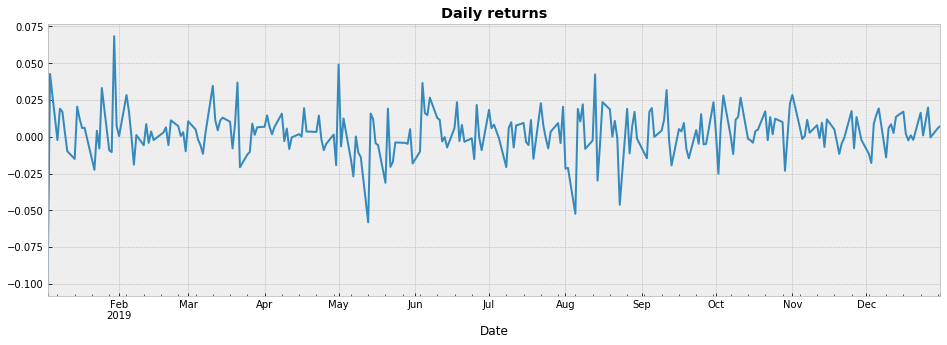

In [35]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
plt.title("Daily returns", weight="bold")

plt.show()

In [36]:
VaR_HS_01 = ret.quantile(0.01)
VaR_HS_05 = ret.quantile(0.05)
VaR_HS_10 = ret.quantile(0.10)

In [37]:
print (VaR_HS_01)
print (VaR_HS_05)
print (VaR_HS_10)

-0.04928418118269201
-0.020661184041934344
-0.014618210329974679


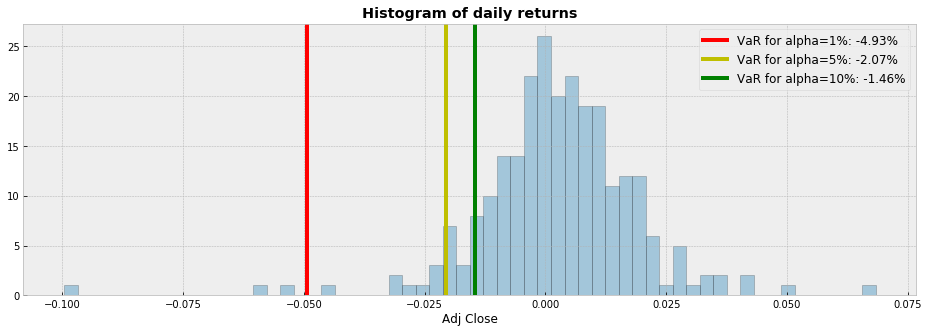

In [38]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(ret, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.axvline(x=VaR_HS_01, linewidth=4, color="r")
plt.axvline(x=VaR_HS_05, linewidth=4, color="y")
plt.axvline(x=VaR_HS_10, linewidth=4, color="g")

plt.title("Histogram of daily returns", weight="bold")

plt.legend(['VaR for alpha=1%: {:.2f}%'.format(100*VaR_HS_01),
            'VaR for alpha=5%: {:.2f}%'.format(100*VaR_HS_05),
            'VaR for alpha=10%: {:.2f}%'.format(100*VaR_HS_10)], fontsize=12)

plt.show()

In [39]:
alpha = 0.05

VaR_HS = ret.quantile(alpha)
ES_HS = ret[ret < VaR_HS].mean()

In [40]:
print(VaR_HS) 
print(ES_HS)

-0.020661184041934344
-0.03680267006282833


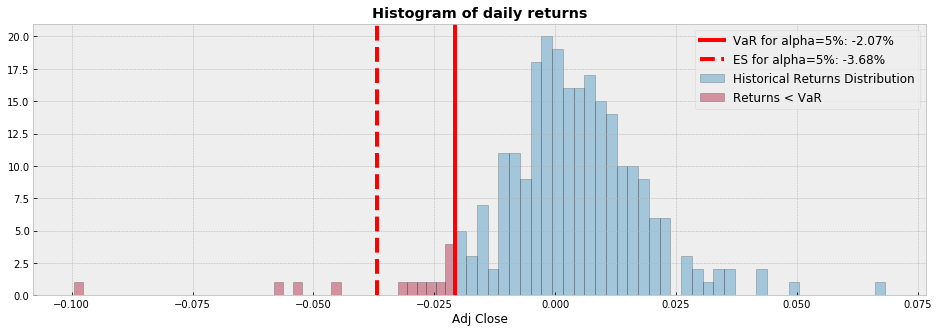

In [41]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(ret[ret >= VaR_HS], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(ret[ret < VaR_HS], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.axvline(x=VaR_HS, linewidth=4, color="r")
plt.axvline(ES_HS, linewidth=4, color='red', linestyle='dashed')

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['VaR for alpha=5%: {:.2f}%'.format(100*VaR_HS),
            'ES for alpha=5%: {:.2f}%'.format(100*ES_HS),
            'Historical Returns Distribution', 
            'Returns < VaR'], fontsize=12)

plt.show()

In [42]:
import scipy.stats as ss

params_norm = ss.norm.fit(ret)
norm_mean, norm_sigma = params_norm

VaR_norm = ss.norm.ppf(alpha, norm_mean, norm_sigma)
ES_norm = ss.norm.expect(loc=norm_mean, scale=norm_sigma, ub=VaR_norm, conditional=True)

print('Estimated parameters: mean={:.2f}, scale={:.2f}'.format(norm_mean, norm_sigma))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_norm))
print('Expected Shortfall: {:.2f}%'.format(100*ES_norm))

Estimated parameters: mean=0.00, scale=0.02
Value-at-Risk: -2.44%
Expected Shortfall: -3.13%


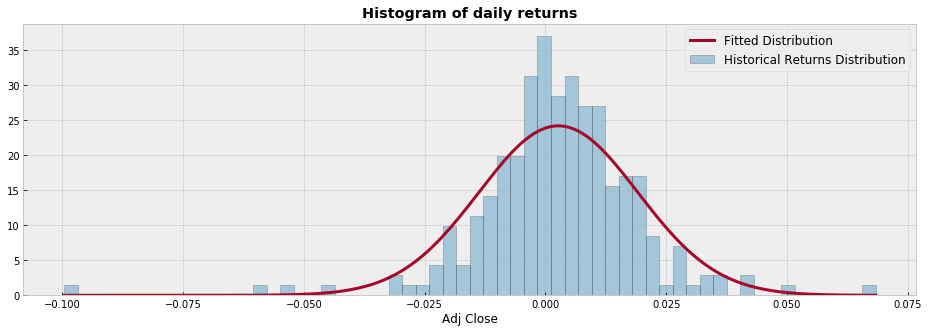

In [43]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

y_pdf = ss.norm.pdf(x, *params_norm)

sns.distplot(ret, hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Returns Distribution'], fontsize=12)

plt.show()

In [44]:
params_t = ss.t.fit(ret)
t_df, t_mean, t_sigma = params_t

VaR_t = ss.t.ppf(alpha, t_df, t_mean, t_sigma)
ES_t = ss.t.expect(args=(t_df,), loc=t_mean, scale=t_sigma, ub=VaR_t, conditional=True)

print('Estimated parameters: df={:.2f}, mean={:.2f}, scale={:.2f}'.format(t_df, t_mean, t_sigma))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_t))
print('Expected Shortfall: {:.2f}%'.format(100*ES_t))

Estimated parameters: df=3.63, mean=0.00, scale=0.01
Value-at-Risk: -2.14%
Expected Shortfall: -3.45%


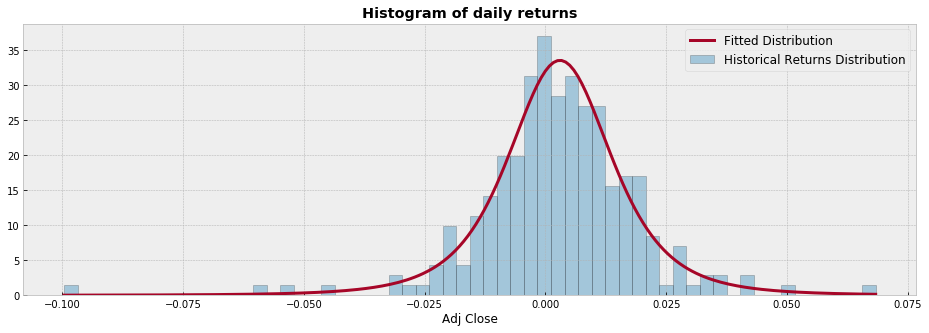

In [45]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

y_pdf = ss.t.pdf(x, *params_t)

sns.distplot(ret, hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Returns Distribution'], fontsize=12)


plt.show()